In [1]:
!pip install tslearn --ignore-installed

     |████████████████████████████████| 374 kB 1.4 MB/s            
     |████████████████████████████████| 302 kB 32.0 MB/s            
     |████████████████████████████████| 15.7 MB 61.4 MB/s            
     |████████████████████████████████| 24.8 MB 57.1 MB/s            
     |████████████████████████████████| 38.1 MB 54.8 MB/s            
     |████████████████████████████████| 3.5 MB 47.0 MB/s            
     |████████████████████████████████| 804 kB 39.6 MB/s            
     |████████████████████████████████| 34.6 MB 57.8 MB/s            
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.6 requires goo

In [2]:
import random
import datetime
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import tslearn
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict
import lightgbm as lgbm

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-apr-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-apr-2022/train_labels.csv
/kaggle/input/tabular-playground-series-apr-2022/train.csv
/kaggle/input/tabular-playground-series-apr-2022/test.csv


# Load data
## Train data

In [3]:
df = pd.read_csv('../input/tabular-playground-series-apr-2022/train.csv')
tot_sequence = len(df.sequence.unique())
tot_subject = len(df.subject.unique())
print(f'We have {tot_sequence} sequences and {tot_subject} subjects.')

df.set_index(['sequence', 'subject'], drop=False, inplace=True)
df.drop('step', axis=1, inplace=True)
df.head()

We have 25968 sequences and 672 subjects.


sequence  subject  sensor_00  sensor_01  sensor_02  \
sequence subject                                                       
0        47              0       47  -0.196291   0.112395        1.0   
         47              0       47  -0.447450   0.134454        1.0   
         47              0       47   0.326893  -0.694328        1.0   
         47              0       47   0.523184   0.751050        1.0   
         47              0       47   0.272025   1.074580        1.0   

                  sensor_03  sensor_04  sensor_05  sensor_06  sensor_07  \
sequence subject                                                          
0        47        0.329204  -1.004660  -0.131638  -0.127505   0.368702   
         47       -0.658407   0.162495   0.340314  -0.209472  -0.867176   
         47        0.330088   0.473678   1.280479  -0.094718   0.535878   
         47        0.976991  -0.563287  -0.720269   0.793260   0.951145   
         47       -0.136283   0.398579   0.044877   0.560109  -0.541985   

                  sensor_08  sensor_09  sensor_10  sensor_11  sensor_12  
sequence subject                                                         
0        47            -0.1  -0.963873  -0.985069   0.531893   4.751492  
         47             0.2  -0.301301   0.082733  -0.231481   0.454390  
         47             1.4   1.002168   0.449221  -0.586420  -4.736147  
         47            -0.3  -0.995665  -0.434290   1.344650   0.429241  
         47            -0.9   1.055636   0.812631   0.123457  -0.223359

## Test data

In [4]:
df_test = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2022/test.csv')
tot_sequence_test = len(df_test.sequence.unique())
print(f'We have {tot_sequence_test} sequences and {len(df_test.subject.unique())} subjects.')

df_test.set_index(['sequence', 'subject'], drop=False, inplace=True)
df_test.drop('step', axis=1, inplace=True)
df_test.head()

We have 12218 sequences and 319 subjects.


sequence  subject  sensor_00  sensor_01  sensor_02  \
sequence subject                                                       
25968    684         25968      684   2.427357  19.639706        1.0   
         684         25968      684  -4.950541 -21.747899        1.0   
         684         25968      684   1.136012 -10.756303        1.0   
         684         25968      684   0.806028   6.504202        1.0   
         684         25968      684   1.288253   5.552521        1.0   

                  sensor_03  sensor_04  sensor_05  sensor_06  sensor_07  \
sequence subject                                                          
25968    684      -1.466372  -1.289973  -4.207928   2.486339  -2.493893   
         684       0.983186  -0.569053   1.845924  -3.887978   1.727481   
         684       1.016814   0.964157   2.454749   0.312386   1.154198   
         684      -0.179646   0.969221  -1.035153  -0.457195   0.254962   
         684      -0.493805  -1.036124  -1.126402   2.008197  -0.730534   

                  sensor_08  sensor_09  sensor_10  sensor_11  sensor_12  
sequence subject                                                         
25968    684            8.0  -1.123555  -1.673048  10.980453   0.419011  
         684           -2.9   0.395231  -0.882233  -1.871399  -0.008525  
         684           -5.6   1.114162   1.525273 -11.584362   0.139812  
         684           -2.7  -0.588873   0.608761  -4.241770  -0.462916  
         684            0.0   0.899566  -1.259615  -0.472222  -0.121483

In [5]:
# all sequence has complete 60 seconds time step
np.sum(df.isna(), axis=0)

sequence     0
subject      0
sensor_00    0
sensor_01    0
sensor_02    0
sensor_03    0
sensor_04    0
sensor_05    0
sensor_06    0
sensor_07    0
sensor_08    0
sensor_09    0
sensor_10    0
sensor_11    0
sensor_12    0
dtype: int64

## Load labels

In [6]:
df_label = pd.read_csv('../input/tabular-playground-series-apr-2022/train_labels.csv')
df_label.head(10)

,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1
5,5,1
6,6,0
7,7,0
8,8,0
9,9,0


# Turn `df` into a 3D matrix

In [7]:
df.drop(['sequence', 'subject'], axis=1, inplace=True)
df_test.drop(['sequence', 'subject'], axis=1, inplace=True)

In [8]:
print(df.shape[1] == df_test.shape[1])

def get_3D(data, total_seq):
    new_data = np.zeros((total_seq, 60, 13))
    for i in range(total_seq):
        new_data[i] = data.loc[i]
    return new_data

def get_3D_test(data, total_seq):
    new_data = np.zeros((total_seq, 60, 13))
    for i in range(total_seq):
        # in test dataset, the index starts 25968, which is
        # the total sequence (tot_sequence) in the train dataset.
        new_data[i] = data.loc[i + tot_sequence]
    return new_data

True


In [9]:
df_3d = get_3D(df, tot_sequence)
df_test_3d = get_3D_test(df_test, tot_sequence_test)

In [10]:
print(df_3d.shape)
print(df_test_3d.shape)

(25968, 60, 13)
(12218, 60, 13)


### and split the dataset into train and valid

In [11]:
rnd = np.random.default_rng(8)
trainid = rnd.choice(tot_sequence, replace=False, size=int(0.8*tot_sequence))
validid = [i for i in list(range(tot_sequence)) if i not in trainid]

In [12]:
# the sequences are splitted perfectly into 2 groups
set(trainid).intersection(set(validid))

set()

In [13]:
train_X = df_3d[trainid, :]
valid_X = df_3d[validid, :]

train_y = df_label.loc[trainid, 'state']
valid_y = df_label.loc[validid, 'state']

In [14]:
train_X.shape

(20774, 60, 13)

# Visualization

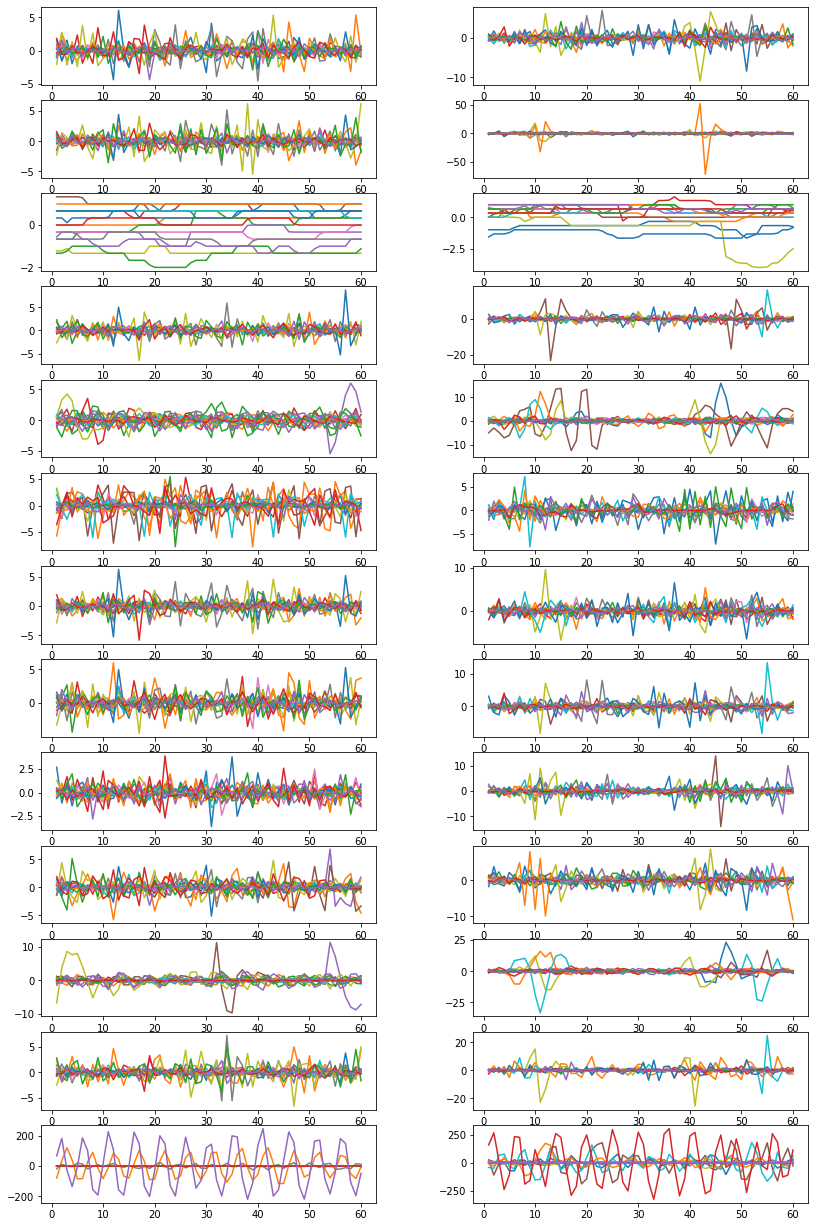

In [15]:
rnd = np.random.default_rng()

state0 = df_3d[df_label.state==0]
state1 = df_3d[df_label.state==1]

fig = plt.figure(figsize=(12, 22))
sfigs = fig.subfigures(1, 2)
axsL = sfigs[0].subplots(13, 1)
axsR = sfigs[1].subplots(13, 1)

for ts in range(15):
    # choose a sequence
    seq = rnd.choice(state0.shape[0])
    
    for sensor in range(13):
        # plot each sensor from the sequence
        axsL[sensor].plot(np.arange(1, 61), state0[seq, :, sensor])
        
for ts in range(15):
    # choose a sequence
    seq = rnd.choice(state1.shape[0])
    
    for sensor in range(13):
        # plot each sensor from the sequence
        axsR[sensor].plot(np.arange(1, 61), state1[seq, :, sensor])

# Shapelet transformation

I only use 30% of the train dataset to learn the shapelets.

In [16]:
random.seed(99)
# we're taking only 30% of the train dataset
PERCENTAGE = 0.3
train_sequence_we_want = random.sample(set(trainid), k=int(PERCENTAGE*len(trainid)))

# but the 3D datasets are in ndarray, so there must be some sequence numbers which are bigger than the 3D matrix size
# so, we need to take True and False for each data
train_or_no = np.isin(trainid, train_sequence_we_want)

In [17]:
# get a dictionary of how many shapelets (value) to be found for each shapelet length (key)
shapelet_dict = grabocka_params_to_shapelet_size_dict(n_ts=int(0.3*len(trainid)), ts_sz=60, n_classes=2, l=0.15, r=5)
shapelet_dict

{9: 5, 18: 5, 27: 5, 36: 5, 45: 4}

In [18]:
#take the labels which we want to use for learning shapelets
train_y_learning_shapelets = train_y[train_or_no]

# make the shapelet learner class
# weight_regularizer is set to avoid overfitting in learning shapelets
# set scale to True so that the data are scaled first
trans = LearningShapelets(weight_regularizer=0.001, batch_size=512, max_iter=2500, total_lengths=5,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), scale=True)

# dictionaries for storing shapelets learning history
shapelets_learned = {}
lhist = {}

# ndarray for storing the transformed dataset
train_shapelets = None
valid_shapelets = None
test_shapelets = None
shapelets_learned_as_ts = None

for SENSOR in range(13):
    DATA = train_X[train_or_no, :, SENSOR]

    print('Now finding shapelets from sensor', SENSOR, '----', datetime.datetime.now().time())
    trans.fit(DATA, train_y_learning_shapelets)
    
    shapelets_learned[f'{SENSOR}'] = trans.shapelets_
    lhist[f'{SENSOR}'] = trans.history_

    # now that the shapelets have been discovered, we calculate the distances between the shapelets and ALL sequences
    if train_shapelets is None:
        train_shapelets = trans.transform(train_X[:, :, SENSOR])
        valid_shapelets = trans.transform(valid_X[:, :, SENSOR])
        test_shapelets = trans.transform(df_test_3d[:, :, SENSOR])
        shapelets_learned_as_ts = trans.shapelets_as_time_series_
    else:
        train_shapelets = np.hstack((train_shapelets, trans.transform(train_X[:, :, SENSOR])))
        valid_shapelets = np.hstack((valid_shapelets, trans.transform(valid_X[:, :, SENSOR])))
        test_shapelets = np.hstack((test_shapelets, trans.transform(df_test_3d[:, :, SENSOR])))
        shapelets_learned_as_ts = np.vstack((shapelets_learned_as_ts, trans.shapelets_as_time_series_))

print("DONE", datetime.datetime.now().time())

Now finding shapelets from sensor 0 ---- 15:58:53.338035
Now finding shapelets from sensor 1 ---- 16:06:18.023625
Now finding shapelets from sensor 2 ---- 16:13:12.081884
Now finding shapelets from sensor 3 ---- 16:18:55.245102
Now finding shapelets from sensor 4 ---- 16:25:51.001175
Now finding shapelets from sensor 5 ---- 16:32:58.173765
Now finding shapelets from sensor 6 ---- 16:40:19.586177
Now finding shapelets from sensor 7 ---- 16:47:16.747349
Now finding shapelets from sensor 8 ---- 16:53:51.792705
Now finding shapelets from sensor 9 ---- 17:01:12.677943
Now finding shapelets from sensor 10 ---- 17:08:25.900279
Now finding shapelets from sensor 11 ---- 17:15:09.051141
Now finding shapelets from sensor 12 ---- 17:22:17.641119
DONE 17:29:04.153532


In [19]:
print(train_shapelets.shape)
print(valid_shapelets.shape)
print(test_shapelets.shape)

(20774, 312)
(5194, 312)
(12218, 312)


In [20]:
np.save('train_transformed', train_shapelets)
np.save('valid_transformed', valid_shapelets)
np.save('test_transformed', test_shapelets)
np.save('shapelets_learned_as_ts', shapelets_learned_as_ts)

np.save('train_y', train_y)
np.save('valid_y', valid_y)

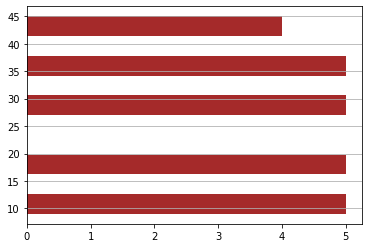

In [21]:
shapelet_sizes = []
for i in range(trans.shapelets_.shape[0]):
    shapelet_sizes.append(len(trans.shapelets_[i]))

plt.hist(shapelet_sizes, color='brown', orientation='horizontal')
plt.grid(axis='y');

# Plotting shapelets

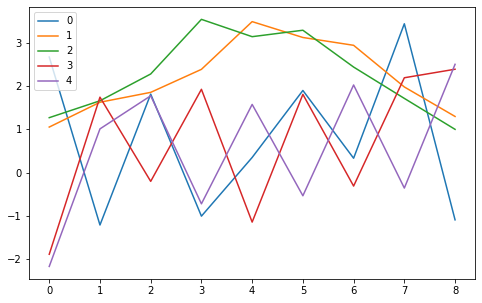

In [22]:
plt.figure(figsize=(8,5))
for i in range(5):
    plt.plot(shapelets_learned['9'][i], label=i)
    plt.legend();

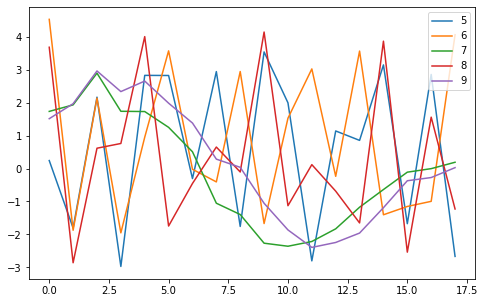

In [23]:
plt.figure(figsize=(8,5))
for i in range(5, 10):
    plt.plot(shapelets_learned['9'][i], label=i)
    plt.legend();

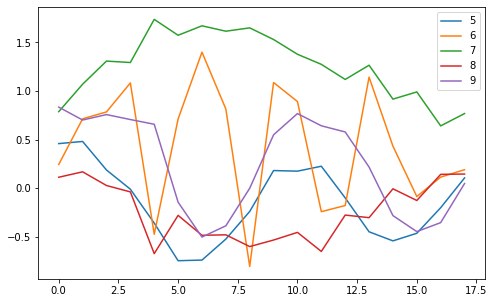

In [24]:
plt.figure(figsize=(8,5))
for i in range(5,10):
    plt.plot(shapelets_learned['5'][i], label=i)
    plt.legend();

## Modeling

In [25]:
import lightgbm as lgbm

In [26]:
model = lgbm.LGBMClassifier(n_estimators = 3500, random_state=8)
model.fit(train_shapelets, train_y, eval_set=[(valid_shapelets, valid_y)], eval_metric='AUC')

[1]	valid_0's auc: 0.833566	valid_0's binary_logloss: 0.658141
[2]	valid_0's auc: 0.846378	valid_0's binary_logloss: 0.628651
[3]	valid_0's auc: 0.851047	valid_0's binary_logloss: 0.604559
[4]	valid_0's auc: 0.855682	valid_0's binary_logloss: 0.584087
[5]	valid_0's auc: 0.860242	valid_0's binary_logloss: 0.565224
[6]	valid_0's auc: 0.8635	valid_0's binary_logloss: 0.549206
[7]	valid_0's auc: 0.865281	valid_0's binary_logloss: 0.535688
[8]	valid_0's auc: 0.868467	valid_0's binary_logloss: 0.523037
[9]	valid_0's auc: 0.869932	valid_0's binary_logloss: 0.512412
[10]	valid_0's auc: 0.871779	valid_0's binary_logloss: 0.503054
[11]	valid_0's auc: 0.873631	valid_0's binary_logloss: 0.494468
[12]	valid_0's auc: 0.874927	valid_0's binary_logloss: 0.486493
[13]	valid_0's auc: 0.87608	valid_0's binary_logloss: 0.47966
[14]	valid_0's auc: 0.87685	valid_0's binary_logloss: 0.473787
[15]	valid_0's auc: 0.878095	valid_0's binary_logloss: 0.467989
[16]	valid_0's auc: 0.87885	valid_0's binary_logloss: 

LGBMClassifier(n_estimators=3500, random_state=8)

# Submit

In [27]:
subs = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2022/sample_submission.csv')
subs.head()

,sequence,state
0,25968,0
1,25969,0
2,25970,0
3,25971,0
4,25972,0


In [28]:
subs['state'] = model.predict_proba(test_shapelets)[:,1]
subs.head()

,sequence,state
0,25968,1.000000e+00
1,25969,9.999988e-01
2,25970,3.964019e-16
3,25971,4.888880e-04
4,25972,9.875830e-01


In [29]:
subs.to_csv('my_subs.csv', index=False)